# Predicting the Adoption or Transfer of Cats based on Physical Attributes

#### In this model, we are predicting the adoption or transfer of cats based on their physical characteristics. We are using data from Austin Animal Center, the largest no-kill shelter in the United States. As part of the City of Austin's Open Data Initative, the shelter makes their data available to the general public. The CSV file is posted on Kaggle.com at https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-outcomes-and?select=aac_shelter_cat_outcome_eng.csv

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

import joblib

import warnings 
warnings.simplefilter('ignore')

In [5]:
df = pd.read_csv("aac_shelter_cat_outcome_eng.csv")
print(len(df))
df.head()

29421


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,outcome_weekday,outcome_hour,breed1,breed2,cfa_breed,domestic_breed,coat_pattern,color1,color2,coat
0,2 weeks,A684346,Cat,domestic shorthair,orange,7/7/2014 0:00,7/22/2014 16:04,2014-07-22T16:04:00,NaN,Partner,...,Tuesday,16,domestic shorthair,NaN,False,True,tabby,orange,NaN,orange
1,1 month,A685067,Cat,domestic shorthair,blue /white,6/16/2014 0:00,8/14/2014 18:45,2014-08-14T18:45:00,Lucy,NaN,...,Thursday,18,domestic shorthair,NaN,False,True,tabby,blue,white,blue
2,3 months,A678580,Cat,domestic shorthair,white/black,3/26/2014 0:00,6/29/2014 17:45,2014-06-29T17:45:00,*Frida,Offsite,...,Sunday,17,domestic shorthair,NaN,False,True,NaN,white,black,white
3,1 year,A675405,Cat,domestic mediumhair,black/white,3/27/2013 0:00,3/28/2014 14:55,2014-03-28T14:55:00,Stella Luna,NaN,...,Friday,14,domestic mediumhair,NaN,False,True,NaN,black,white,black
4,3 weeks,A670420,Cat,domestic shorthair,black/white,12/16/2013 0:00,1/9/2014 19:29,2014-01-09T19:29:00,NaN,Partner,...,Thursday,19,domestic shorthair,NaN,False,True,NaN,black,white,black


In [6]:
print(df.dtypes)

age_upon_outcome         object
animal_id                object
animal_type              object
breed                    object
color                    object
date_of_birth            object
datetime                 object
monthyear                object
name                     object
outcome_subtype          object
outcome_type             object
sex_upon_outcome         object
count                     int64
sex                      object
Spay/Neuter              object
Periods                   int64
Period Range              int64
outcome_age_(days)        int64
outcome_age_(years)     float64
Cat/Kitten (outcome)     object
sex_age_outcome          object
age_group                object
dob_year                  int64
dob_month                 int64
dob_monthyear            object
outcome_month             int64
outcome_year              int64
outcome_monthyear        object
outcome_weekday          object
outcome_hour              int64
breed1                   object
breed2  

In [7]:
df['age_group'] = pd.cut(df['outcome_age_(years)'], 10)
df['age_group'].value_counts()

age_group
(-0.022, 2.2]    25107
(2.2, 4.4]        1554
(4.4, 6.6]         901
(6.6, 8.8]         724
(8.8, 11.0]        599
(11.0, 13.2]       297
(13.2, 15.4]       151
(15.4, 17.6]        58
(17.6, 19.8]        16
(19.8, 22.0]        14
Name: count, dtype: int64

In [8]:
df['date_of_birth'].head()

0      7/7/2014 0:00
1     6/16/2014 0:00
2     3/26/2014 0:00
3     3/27/2013 0:00
4    12/16/2013 0:00
Name: date_of_birth, dtype: object

In [9]:
#Converting date columns into workable formats
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['dob_year'] = df['date_of_birth'].dt.year
df['dob_month'] = df['date_of_birth'].dt.month
df['dob_monthyear'] = pd.to_datetime(df['monthyear'])

In [11]:
df['datetime'].head()

0    7/22/2014 16:04
1    8/14/2014 18:45
2    6/29/2014 17:45
3    3/28/2014 14:55
4     1/9/2014 19:29
Name: datetime, dtype: object

In [12]:
#Converting date columns into workable formats
df['datetime'] = pd.to_datetime(df['datetime'])
df['outcome_year'] = df['datetime'].dt.year
df['outcome_month'] = df['datetime'].dt.month
df['outcome_weekday'] = df['datetime'].dt.day_name
df['outcome_hour'] = df['datetime'].dt.hour

In [13]:
print(df.dtypes)

age_upon_outcome                object
animal_id                       object
animal_type                     object
breed                           object
color                           object
date_of_birth           datetime64[ns]
datetime                datetime64[ns]
monthyear                       object
name                            object
outcome_subtype                 object
outcome_type                    object
sex_upon_outcome                object
count                            int64
sex                             object
Spay/Neuter                     object
Periods                          int64
Period Range                     int64
outcome_age_(days)               int64
outcome_age_(years)            float64
Cat/Kitten (outcome)            object
sex_age_outcome                 object
age_group                     category
dob_year                         int32
dob_month                        int32
dob_monthyear           datetime64[ns]
outcome_month            

In [14]:
df['breed'].value_counts()

breed
domestic shorthair                      23720
domestic mediumhair                      2454
domestic longhair                        1273
siamese                                  1058
american shorthair                        211
                                        ...  
snowshoe/domestic shorthair                 1
domestic longhair/russian blue              1
havana brown                                1
domestic shorthair/british shorthair        1
domestic mediumhair/manx                    1
Name: count, Length: 65, dtype: int64

In [15]:
df['outcome_type'].value_counts()

outcome_type
Transfer           13323
Adoption           12732
Euthanasia          1452
Return to Owner     1431
Died                 403
Rto-Adopt             33
Missing               28
Disposal              16
Name: count, dtype: int64

#### This learning machine model is focusing only on adoption and transfer outcomes. The dataset lacks key information (e.g., diseases, behavioral issues) needed to analyze the other outcomes like euthanasia, return to owner, or death. Over 90% of the outcomes are adoptions or transfers, so a model predicting these outcomes is valuable.

In [17]:
#Trimming the dataset
df_filtered = df[df['outcome_type'].isin(['Adoption', 'Transfer'])]

### Visual Analysis of the Dataset

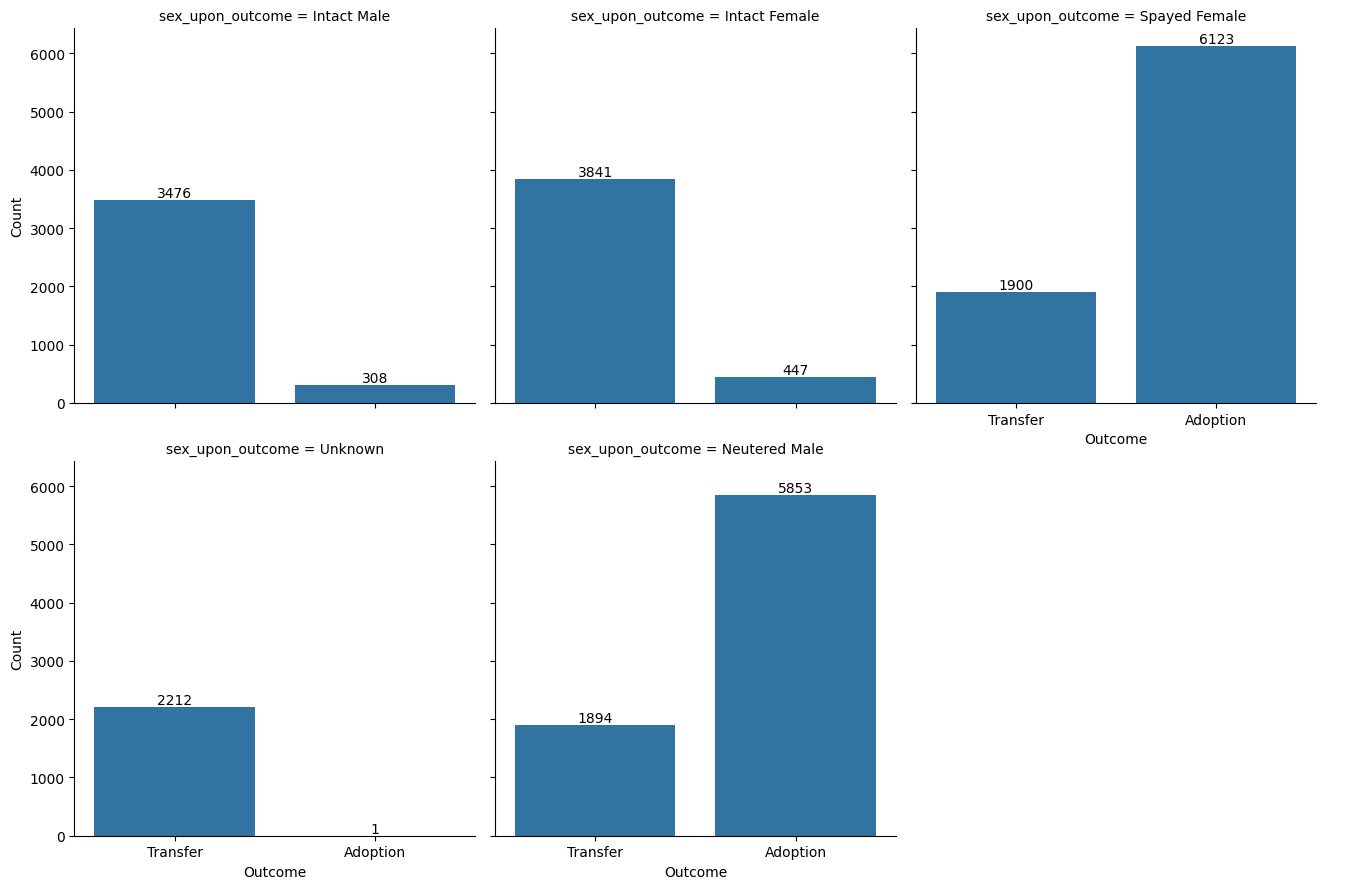

In [31]:
#Graphing the distribution of adopted or transfered cats based on sex and intact status
g = sns.catplot(x='outcome_type', col='sex_upon_outcome', col_wrap=3, data=df_filtered, kind='count', height=4.5)

g.set_axis_labels('Outcome', 'Count')

for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', fontsize=10, color='black',  xytext=(0, 5), textcoords='offset points')

g.tight_layout()
plt.show()

#### Observations: 
#### Fixed cats of either sex are more likely to be adopted than transferred. 
#### Intact cats of either sex have a higher likelihood of being transferred than adopted. 

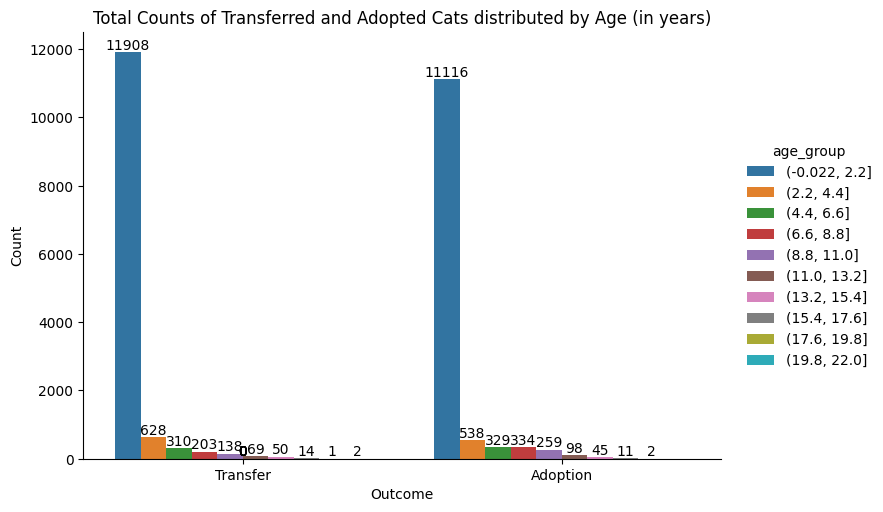

In [34]:
#Graphing the total counts of adopted and transferred cats distributed by age
g = sns.catplot(x='outcome_type', hue='age_group', data=df_filtered, kind='count', height=5, aspect=1.5)

g.set_axis_labels('Outcome', 'Count')

for ax in g.axes.flat:
    for p in ax.patches:  
        ax.annotate(f'{int(p.get_height())}',  (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

g.tight_layout()
plt.title('Total Counts of Transferred and Adopted Cats distributed by Age (in years)')
plt.show()

#### Observations:
#### The age of the cat seems to have no direct influence on whether the cat is adopted or transferred. 
#### Cats that are 2.2 years or younger compose a majority of the data.

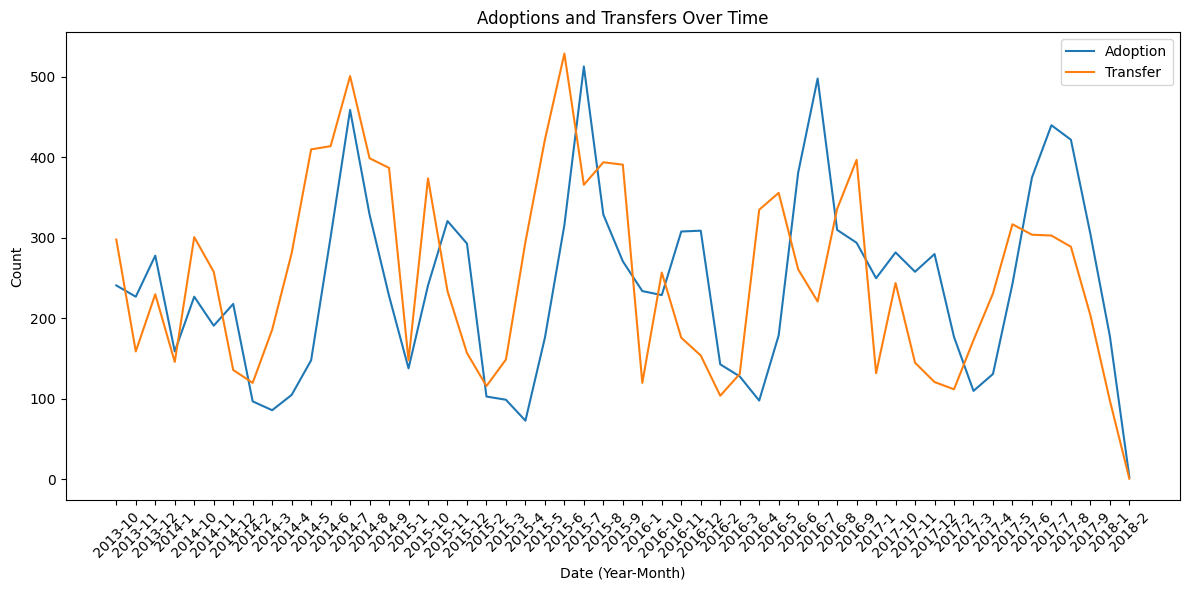

In [37]:
# Group by outcome month-year and outcome type, then sum counts
overtime = df_filtered.groupby(['outcome_monthyear', 'outcome_type'])['count'].sum().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(overtime.index, overtime['Adoption'], label='Adoption')
plt.plot(overtime.index, overtime['Transfer'], label='Transfer')

# Formatting the plot
plt.title('Adoptions and Transfers Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Observation:
#### The graph has large, annual spikes in the middle months. Various factors could play into this trend, but it's most probable that early spring/late summer births (kitten season) have a strong influence. 

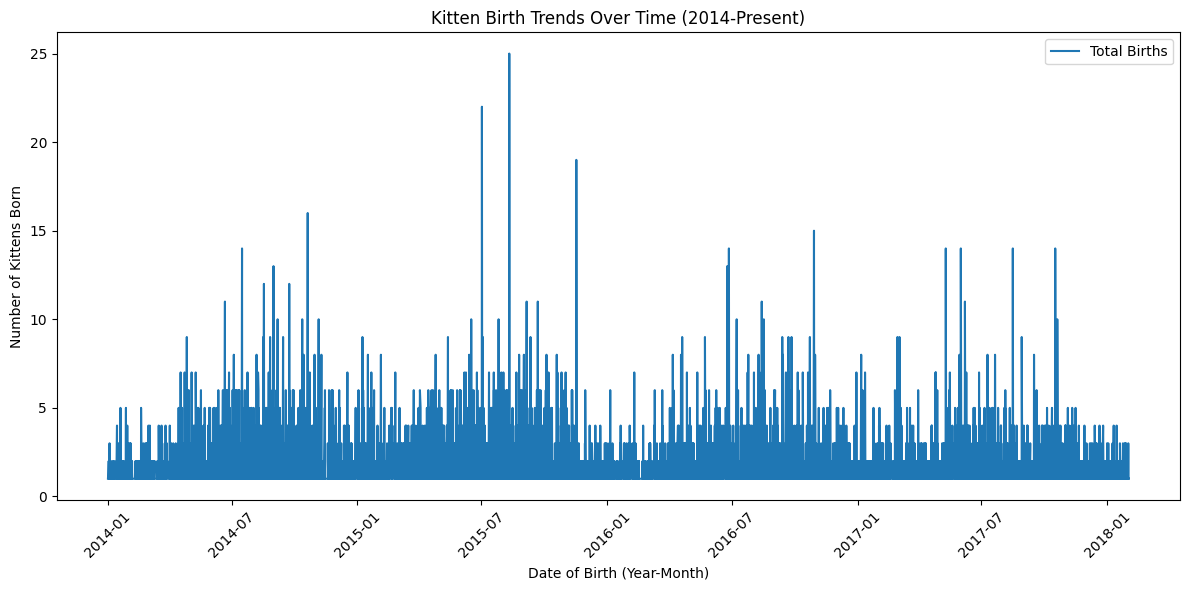

In [40]:
#Graphing birth trends over time
b = df_filtered[df_filtered['dob_monthyear'].dt.year >= 2014]
b = b.groupby('dob_monthyear')['count'].sum()

plt.figure(figsize=(12, 6))
plt.plot(b.index, b.values, label='Total Births')

plt.title("Kitten Birth Trends Over Time (2014-Present)")
plt.xlabel("Date of Birth (Year-Month)")
plt.ylabel("Number of Kittens Born")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

#### Observation:
#### The large spikes in the middle of the years support the theory that high adopted and transferred rates in the middle months is from kitten season

### Predicting Shelter Cat Adoption vs. Transfer

In [60]:
#Prepping the data
x = df_filtered.filter(items=['sex_upon_outcome', 'breed', 'color', 'domestic_breed', 'dob_month', 'age_group', 'outcome_month', 'outcome_weekday', 'outcome_hour'])

In [62]:
#Converting the column data types into cat-egorical
for col in x:
    x[col] = x[col].astype('category')
    
y = df_filtered['outcome_type'].astype('category')

In [64]:
#Converting into indicator variables (0s and 1s)
xd = pd.get_dummies(x)
xnames = xd.columns
xarr = np.array(xd)

In [66]:
yarr, ynames = pd.factorize(y)

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(xarr, yarr, test_size=0.3, random_state=1)

In [70]:
scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
randomForest = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', bootstrap=True, oob_score=True).fit(X_train, Y_train)

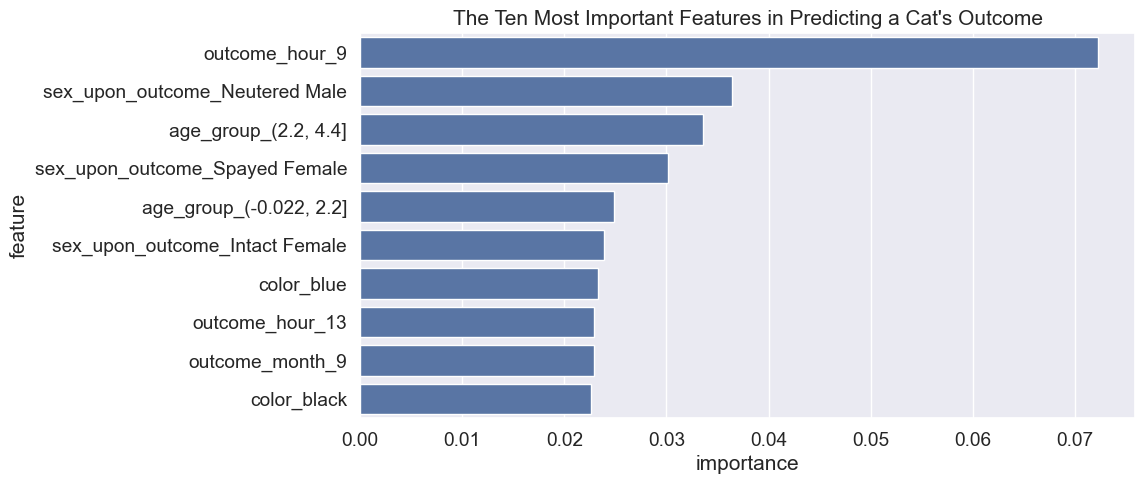

In [57]:
feature_importances = randomForest.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.25)
plt.figure(figsize=(10, 5))

plt.title("The Ten Most Important Features in Predicting a Cat's Outcome")
sns.barplot(x='importance', y='feature', data=importances[0:10])
plt.show()

#### Observations: 

In [74]:
#Reducing dimensionality 
pca = PCA().fit(X_train_scaled)

In [75]:
print(len(pca.components_))

266


In [76]:
#Utilizing FeatureUnion to transform/concatenate results
funion = FeatureUnion([('pca', PCA()), ('kbest', SelectKBest())])

In [77]:
prediction_model = Pipeline([('funion', funion), ('rf', RandomForestClassifier(n_estimators=1000, criterion='gini', class_weight='balanced_subsample', bootstrap=True, oob_score=True))])

In [78]:
prediction_model.fit(X_train_scaled, Y_train)

Pipeline(steps=[('funion',
                 FeatureUnion(transformer_list=[('pca', PCA()),
                                                ('kbest', SelectKBest())])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=1000, oob_score=True))])

In [79]:
cv = StratifiedKFold(2)

In [80]:
cv_score = cross_val_score(prediction_model, X_train_scaled, Y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, X_train_scaled, Y_train, cv=cv)

In [81]:
print(cv_score)
print(np.mean(cv_score))
print(accuracy_score(Y_train, cv_predict_score))

[0.85426034 0.85776949]
0.8560149139159996
0.8568922030924443


In [82]:
rf_pred = prediction_model.predict(X_test_scaled)

In [83]:
#Returning the accuracy score of the predicted outcomes on the actual outcomes 
print(accuracy_score(Y_test, rf_pred))

0.8600486119994883


In [84]:
#Creating a matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Normalized confusion matrix
Confusion matrix, without normalization


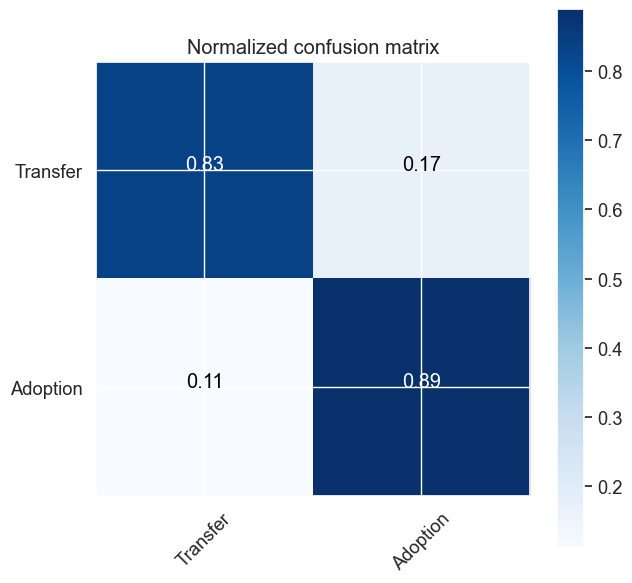

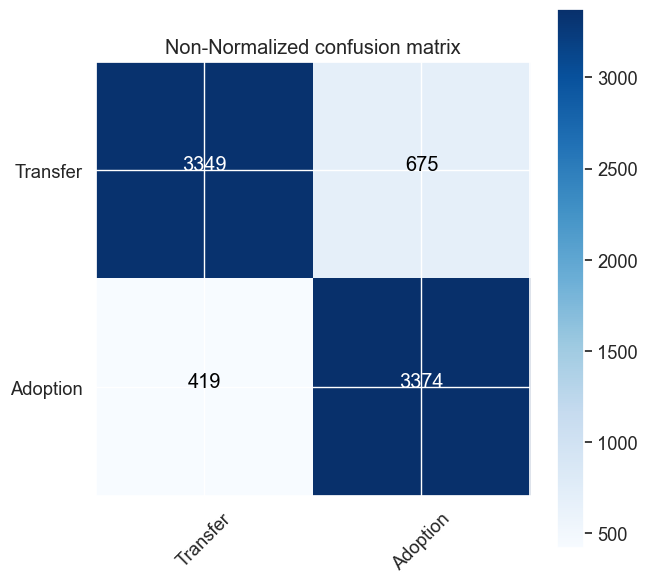

In [85]:
#PLotting the matrix
sns.set(font_scale=1.2)

rf_cnf_mat = confusion_matrix(Y_test, rf_pred)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=False, title='Non-Normalized confusion matrix')

plt.show()

In [86]:
print(classification_report(Y_test, rf_pred, target_names=ynames))

              precision    recall  f1-score   support

    Transfer       0.89      0.83      0.86      4024
    Adoption       0.83      0.89      0.86      3793

    accuracy                           0.86      7817
   macro avg       0.86      0.86      0.86      7817
weighted avg       0.86      0.86      0.86      7817



## Conclusion

#### The classification report indicates that the model had an overall accuracy of 86%, with balanced precision and recall values for both classes. These insights suggest that the model is reliable for making predictions, though there is still room for improvement, particularly in reducing misclassification errors between the two outcomes. Further optimization, such as increased feature engineering or hyperparameter tuning, may help boost the model’s performance. 


#### While using the model, it is important to recognize that the dataset does not capture critical factors in adoption decisions, such as animal behavior, health conditions, or adopter preferences. Because of the lack of this information, the model should be used as a supportive tool rather than a sole decision-maker. Incorporating additional qualitative data, such as behavioral assessments and medical history, could improve prediction accuracy and provide a more comprehensive view of adoption outcomes. 